In [18]:
import pandas as pd
import seaborn as sns

In [19]:
import numpy as np
from glob import glob
from json import loads

glob_path = "./**/test/history/**/*.json"

runs = []
for run_output_filepath in glob(glob_path, recursive=True):
    with open(run_output_filepath) as run_output:
        run_json = loads(run_output.read())
        runs.append(run_json)

if not runs:
    raise Exception("No runs found")
else:
    print(f"Found {len(runs)} runs")


df = pd.DataFrame(runs)
df = df.rename(columns={
    "lang": "language"
})
df = df.assign(
    payload=lambda df: df["payload"]
    .map(lambda payload: loads(payload.replace('"; "', '", "'))),

    runtime=lambda df: df["runtime"].astype(float),
    roundTripTime=lambda df: df["roundTripTime"].astype(float),
    newcontainer=lambda df: df["newcontainer"].astype(int),

    filter=lambda df: df["payload"].map(lambda payload: payload["filter"]),
    filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
    container_state=lambda df: np.where(
        df["newcontainer"] == 1, "cold", "hot"
    ),
    language=lambda df: df["language"].map({
        "java": "Java",
        "node.js": "JavaScript",
    }),
)
df = df[df["filter"] != "flipVertical"]

Found 7460 runs


In [20]:
grouped_columns = [
    # "cpuType",
    "filename", "filter", "container_state", "language",
]
runtime_results = df[df["filename"] == "husky.jpeg"].groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

runtime_results

average runtime (ms)  \
filename   filter         container_state language                           
husky.jpeg flipHorizontal cold            Java                 8130.685393   
                                          JavaScript            892.542373   
                          hot             Java                  670.805755   
                                          JavaScript            578.521739   
           greyscale      cold            Java                 7971.816667   
                                          JavaScript            906.884615   
                          hot             Java                  505.589744   
                                          JavaScript            588.085185   
           soften         cold            Java                 8104.696629   
                                          JavaScript            896.055556   
                          hot             Java                  713.283465   
                                          JavaScript            604.040404   

                                                      standard deviation  \
filename   filter         container_state language                         
husky.jpeg flipHorizontal cold            Java                695.339119   
                                          JavaScript          141.861798   
                          hot             Java                402.105020   
                                          JavaScript          179.688129   
           greyscale      cold            Java                632.929231   
                                          JavaScript          216.412701   
                          hot             Java                227.127842   
                                          JavaScript          186.944588   
           soften         cold            Java                769.117963   
                                          JavaScript          109.787860   
                          hot             Java                404.333155   
                                          JavaScript          151.000717   

                                                      sample size  
filename   filter         container_state language                 
husky.jpeg flipHorizontal cold            Java                 89  
                                          JavaScript           59  
                          hot             Java                139  
                                          JavaScript          207  
           greyscale      cold            Java                120  
                                          JavaScript           52  
                          hot             Java                156  
                                          JavaScript          270  
           soften         cold            Java                 89  
                                          JavaScript           54  
                          hot             Java                127  
                                          JavaScript          198

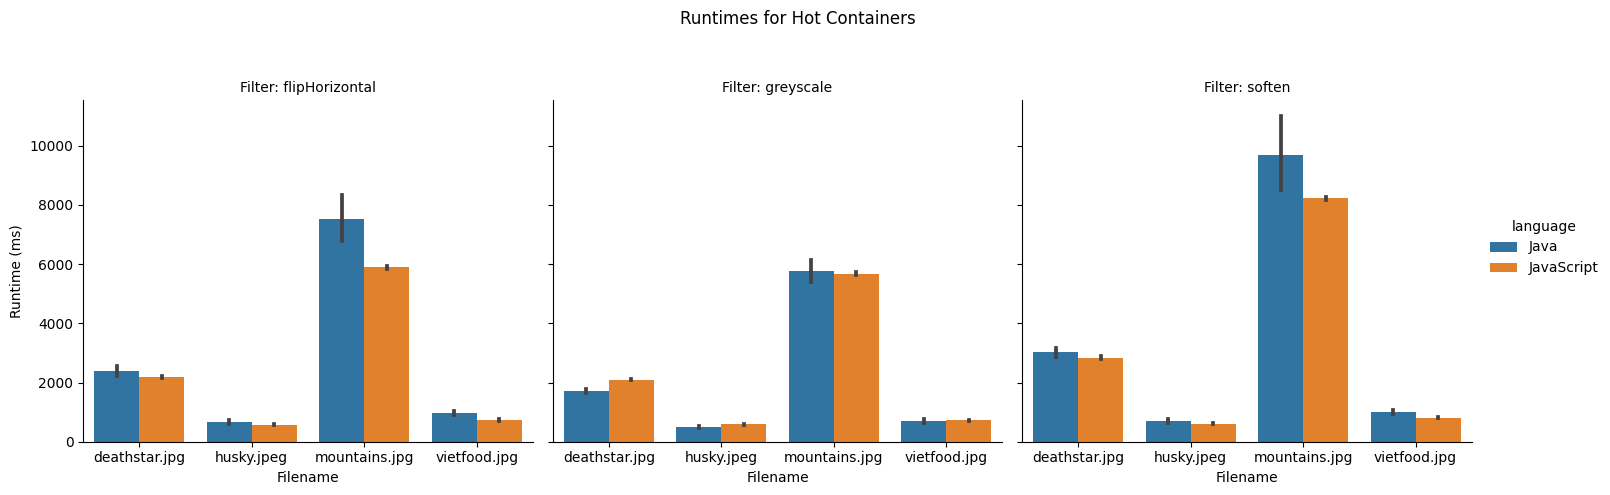

In [21]:
hot_results = sns.catplot(
    df[df["container_state"] == "hot"], x="filename", y="runtime", hue="language",
    col="filter", kind="bar",
)
hot_results.set_axis_labels("Filename", "Runtime (ms)")
hot_results.set_titles("Filter: {col_name}")
hot_results.figure.subplots_adjust(top=0.8)
hot_results.figure.suptitle("Runtimes for Hot Containers")

hot_results

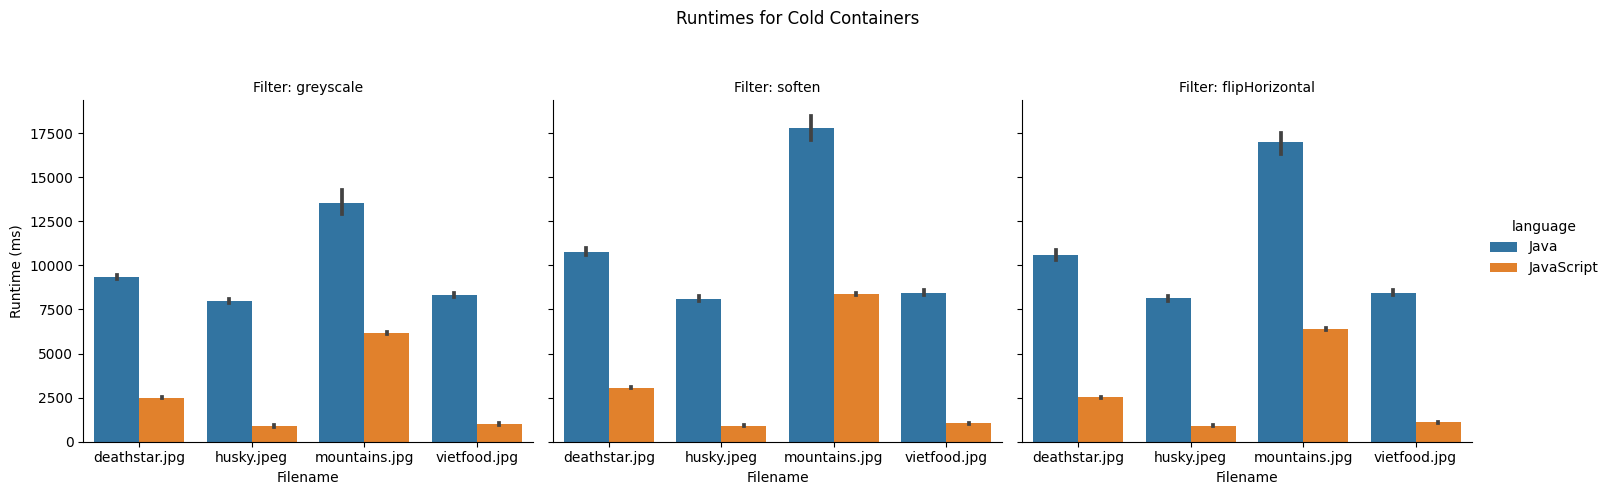

In [22]:
cold_results = sns.catplot(
    df[df["container_state"] == "cold"], x="filename", y="runtime", hue="language",
    col="filter", kind="bar",
)
cold_results.set_axis_labels("Filename", "Runtime (ms)")
cold_results.set_titles("Filter: {col_name}")
cold_results.figure.subplots_adjust(top=0.8)
cold_results.figure.suptitle("Runtimes for Cold Containers")

cold_results

Text(0.5, 0.98, 'Runtimes for Hot/Cold Containers')

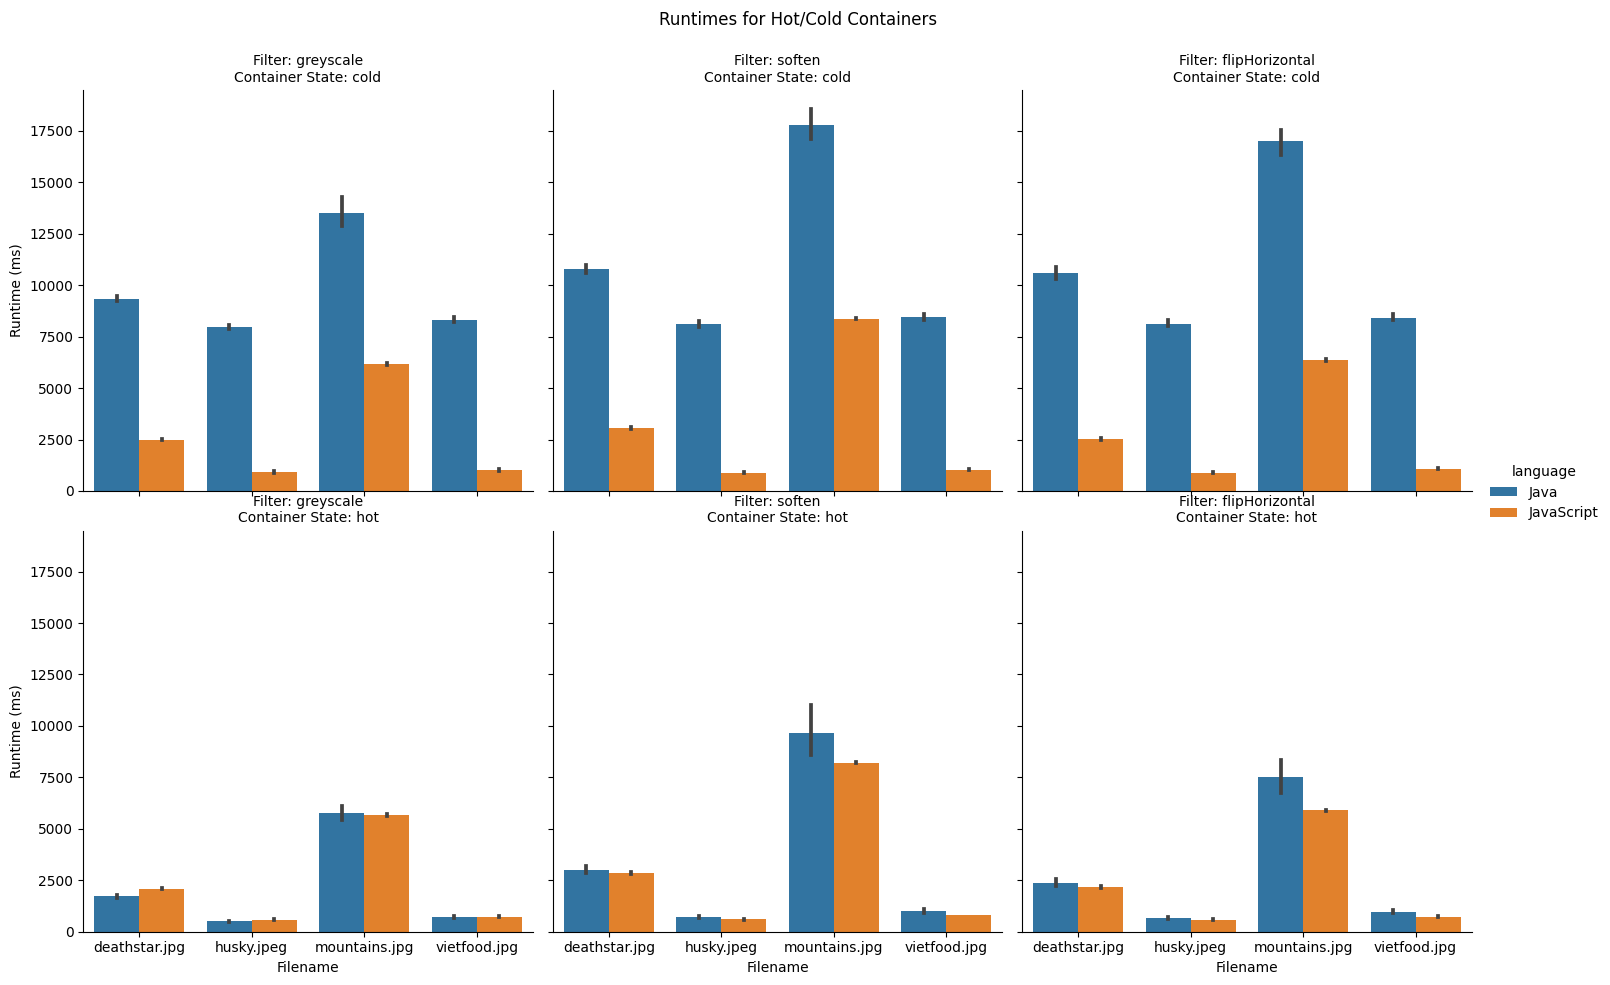

In [26]:
hot_cold_results = sns.catplot(
    df, x="filename", y="runtime", hue="language",
    col="filter", row="container_state", kind="bar",
)
hot_cold_results.set_axis_labels("Filename", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")

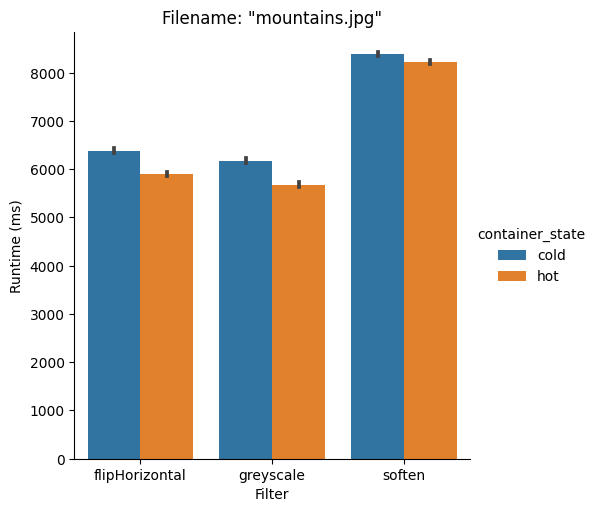

In [30]:
image_filter = "flipVertical"
container_state = "hot"
filename = "deathstar.jpg"

title = f"""
Filter: "{image_filter}"
Container State: "{container_state}"
Filename: "{filename}"
""".strip()

specific_results = sns.catplot(
    df[
        (df["filter"] == image_filter)
        & (df["container_state"] == container_state)
        & (df["filename"] == filename)
    ],
    x="language", y="runtime",
    kind="bar",
)
specific_results.set(title=title)
specific_results.set_xlabels("Language")
specific_results.set_ylabels("Runtime (ms)")

specific_results

AttributeError: Rectangle.set() got an unexpected keyword argument 'c'

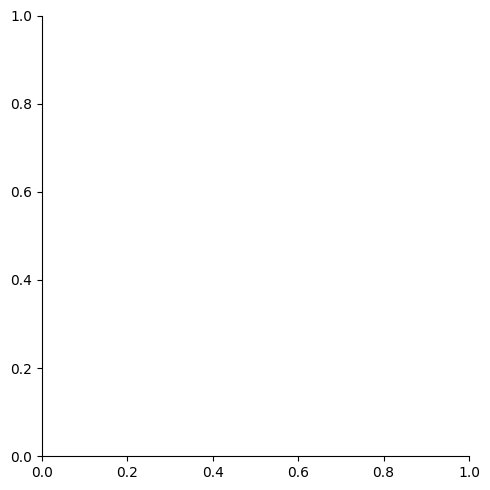

In [34]:
hot_cold_javascript = sns.catplot(
    df[
        (df["language"] == "JavaScript")
    ],
    x="filename", y="runtime",
    hue="container_state",
    kind="bar", palette=["red", "blue"],
)
hot_cold_javascript.set(title="JavaScript Runtimes for Hot/Cold Containers")
hot_cold_javascript.set_xlabels("Filename")
hot_cold_javascript.set_ylabels("Runtime (ms)")

hot_cold_javascript